In [198]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import json
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = True
lr = 0.01
log_interval = 100
num_workers = 0

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")
device = torch.device("cpu")
train_kwargs = {'batch_size': batch_size, 'num_workers' : num_workers}
test_kwargs = {'batch_size': test_batch_size, 'num_workers' : num_workers}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)

class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
         pad[1] = abs(x)
         x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise

In [199]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    print(dataset.data.shape[0])
    for i in range(dataset.data.shape[0]):
        #dataset.data[i,:,:] = shift(dataset.data[i,:,:],-10, 15)
        gaussian = torch.distributions.Normal(loc = 128, scale = 50)# loc = mu, scale = stddev
        
        dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
        

## Agenda
### Big question: CFI for NN


Are we doing complete verification or fuzzing/testing?

What is a `CFI`?

# What is a good abstraction for a NN's structure? Can it be enforced through regularization?
- Distillation? (https://arxiv.org/pdf/1503.02531.pdf)
- Decision Tree? (https://arxiv.org/pdf/1711.09784.pdf)
- Model Extraction? (https://arxiv.org/pdf/2003.04884.pdf)


### Where are we?
We want to do CFI for NN

## Question: Do we want to verify each AP separately? Or we want to tell the difference between activation patterns of real images from fake one using a method M and verify M?



## Option 1: We want to verify each AP separately (we are here)
To be able to do so, we need

### Condition 1: The number of activation patterns for a neural networks has to be way smaller than the size of the training/test set.
#### Why: 

  If every input results in a different AP, given an AP, very likely during infer time every input will have its own AP, so we have to reject it

  We want to verify each AP separately, so smaller the number the better

#### Progress: 

  with the current regularization effort, we have been able to reduce the number of AP to about 20k for 60k input.

#### Aim: 

Reduce to about few hundreds

#### Tricky part: 

Given a network of N layers, we can limit the number of activation patterns by only looking at k < N layers. Question: which k? 

### Condition 2: All, or most, of the activation patterns of the test set has to be covered by the AP of the training set
#### Why: 
If the activation patterns in the test set are completely different from the training set, there would be too many false negative at the inferencing time
#### Progress: 
Possible, but with a big caveat: the fake AP is now also included in the set

### Condition 3: Given an adv exp, its AP cannot be in the training AP set.
#### Progress:
Currently, if Cond.2 is satisfied, then 3 is not.


## Option 2: Train the network s.t the fake AP and real AP can be separated by some methods (linear classifier or a small neural net)

## What are the state-of-the-art attacks and defences?


## Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.
- __BRQ5: Given a target and its corresponding adv. exp, can we gradually move in the in-between space to see at which point the label is changed?__




60000


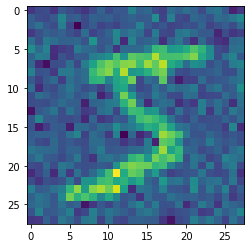

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

ZeroDivisionError: division by zero

In [200]:
#init stuffs
LOAD = True
# LOADPATH = 'TinyCNNreg.conv1.conv2.fc1.fc2.17:09:00'
LOADPATH = 'FFN18_28_21'
RELUPATH = 'relu_exp_data16-06-03.json'
# LOADPATH = 'TinyCNNreg.fc1.fc2.16:06:26'
LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)

transform_dataset(dataset1)
transform_dataset(dataset2)


#for i in range(dataset1.train_data.shape[0]):
#    dataset1.train_data[i,:,:] = shift(dataset1.train_data[i,:,:], 10,-15)
train_loader = torch.utils.data.DataLoader(dataset1,  **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
plt.imshow(dataset1.train_data[0,:,:])
plt.plot()
model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)
if LOAD:
    model.load_state_dict(torch.load(LOADPATH, map_location=device))
    with open(RELUPATH, "r") as f:
        RELU_EXP_DATA = json.load(f)

# Study stable gradients

## Fix a pattern, an input, an epsilon, sample N examples in the surrounding ball, and see if they all have the same pattern

In [ ]:
layers = ['fc1', 'fc2', 'fc3', 'fc4']
labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

# all_patterns = Patterns(model = model,
#                         dataloader = stable_loader,
#                         labels = labels,
#                         layers = layers)
# all_test_patterns = Patterns(model = model,
#                         dataloader = test_loader,
#                         labels = labels,
#                         layers = layers)

torch.Size([1000, 784])
(1000, 458)
epsilon 0.0001
random idx (19, 78)
stable idx (1, 78)
epsilon 0.0005
random idx (16, 116)
stable idx (1, 116)
epsilon 0.001
random idx (9, 136)
stable idx (1, 136)
epsilon 0.005
random idx (47, 177)
stable idx (1, 177)
epsilon 0.01
random idx (76, 205)
stable idx (1, 205)
epsilon 0.05
random idx (283, 261)
stable idx (6, 261)


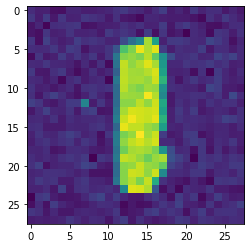

In [ ]:
#checkEPSILON = 5
N_SAMPLES = 1000
EPSILON = 5
N_SAMPLES = 1000
EPSILON = 5
N_SAMPLES = 1000

it = iter(test_loader)
random_data, random_label = next(it)
target_data = random_data[0]
target_label = random_label[0]

neighbors = CFI_utils.sampling_inside_ball(n_samples=N_SAMPLES, n_dim=28*28, origin=target_data.flatten(), r=EPSILON)

class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        label2patterns = {}
        for label in self._labels:
            patterns = []
            for data, target in self._dataloader:
                flter = target == label
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            label2patterns[label] = patterns
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns =dict(label2patterns) # frozendict(label2patterns)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
it = iter(test_loader)
random_data, random_label = next(it)
target_data = random_data[0]
target_label = random_label[0]

neighbors = CFI_utils.sampling_inside_ball(n_samples=N_SAMPLES, n_dim=28*28, origin=target_data.flatten(), r=EPSILON)

class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        label2patterns = {}
        for label in self._labels:
            patterns = []
            for data, target in self._dataloader:
                flter = target == label
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            label2patterns[label] = patterns
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns =dict(label2patterns) # frozendict(label2patterns)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
it = iter(test_loader)
random_data, random_label = next(it)
target_data = random_data[0]
target_label = random_label[0]

neighbors = CFI_utils.sampling_inside_ball(n_samples=N_SAMPLES, n_dim=28*28, origin=target_data.flatten(), r=EPSILON)

class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        label2patterns = {}
        for label in self._labels:
            patterns = []
            for data, target in self._dataloader:
                flter = target == label
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            label2patterns[label] = patterns
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns =dict(label2patterns) # frozendict(label2patterns)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
plt.imshow(neighbors[0].reshape(28,28))
neighbors_tensor = torch.Tensor(np.concatenate([n.unsqueeze(0) for n in neighbors], axis = 0))
print(neighbors_tensor.shape)
neighbor_patterns = model.get_pattern(neighbors_tensor.to(device), layers, device)
print(neighbor_patterns.shape)
for epsilon in ["0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05"]:
    print("epsilon", epsilon)
    stable_idx = RELU_EXP_DATA[epsilon]["1"]["stable_idx"]
    print("random idx", np.unique(neighbor_patterns[:, np.random.choice(458, len(stable_idx), replace = False)] , axis = 0).shape)
    print("stable idx", np.unique(neighbor_patterns[:, stable_idx] , axis = 0).shape)

# RQ: how many ReLUs in the activation pattern of 2 are actually in the activation of 8
## Hypothesis: The confusion matrix shows that: an image for 8 results in an activation pattern very much like an image for 2, but not the other way around. Could it be the case that If you want to know the shape of an 8, you have to know the shape of a 2? Concretely, how many ReLUs in the activation pattern of 2 are actually in the activation of 8? If, say, 90% ReLUs in a 2's activation pattern is actually in activation pattern for 8, it is something really interesting.

In [ ]:
for epsilon in ["0.0001", "0.0005", "0.001", "0.005", "0.01", "0.05"]:
    print("Epsilon", epsilon)
    stable_idx_2 = set(RELU_EXP_DATA[epsilon]["2"]["stable_idx"])
    stable_idx_8 = set(RELU_EXP_DATA[epsilon]["8"]["stable_idx"])

    print("The stable pattern of 2 has {} ReLUs".format(len(stable_idx_2)))
    print("The stable pattern of 8 has {} ReLUs".format(len(stable_idx_8)))

    inte = stable_idx_8.intersection(stable_idx_2)
    print("The intersection has {} ReLUs ~ {}".format(len(inte), len(inte)/len(stable_idx_2)))


Epsilon 0.0001
The stable pattern of 2 has 33 ReLUs
The stable pattern of 8 has 63 ReLUs
The intersection has 28 ReLUs ~ 0.8484848484848485
Epsilon 0.0005
The stable pattern of 2 has 46 ReLUs
The stable pattern of 8 has 94 ReLUs
The intersection has 42 ReLUs ~ 0.9130434782608695
Epsilon 0.001
The stable pattern of 2 has 58 ReLUs
The stable pattern of 8 has 118 ReLUs
The intersection has 53 ReLUs ~ 0.9137931034482759
Epsilon 0.005
The stable pattern of 2 has 102 ReLUs
The stable pattern of 8 has 183 ReLUs
The intersection has 91 ReLUs ~ 0.8921568627450981
Epsilon 0.01
The stable pattern of 2 has 129 ReLUs
The stable pattern of 8 has 209 ReLUs
The intersection has 114 ReLUs ~ 0.8837209302325582
Epsilon 0.05
The stable pattern of 2 has 216 ReLUs
The stable pattern of 8 has 282 ReLUs
The intersection has 187 ReLUs ~ 0.8657407407407407


# RQ: Use the alpha pattern as a regularizer                  

In [ ]:
#cache alpha pattern for faster usage
relu_data = {}

all_stable_relu = [set(RELU_EXP_DATA["0.001"][str(label)]["stable_idx"]) for label in range(10)]
common_stable_relu = set.intersection(*all_stable_relu)
print(common_stable_relu)

for label in range(10):
    stable_idx = RELU_EXP_DATA["0.001"][str(label)]["stable_idx"]
    alpha_pattern = RELU_EXP_DATA["0.001"][str(label)]["alpha_pattern"]
    
    assert(len(stable_idx)==len(alpha_pattern))
    
    """
    compute the reduced alpha pattern: pattern of stable relus that are not stable for all label
    """
    reduced_alpha_pattern = []
    reduced_stable_idx = []
    for idx, relu in enumerate(stable_idx):
        if relu not in common_stable_relu:
            reduced_stable_idx.append(relu)
            reduced_alpha_pattern.append(alpha_pattern[idx])
    print(len(reduced_stable_idx))
    assert(len(reduced_alpha_pattern)==len(set(stable_idx) - common_stable_relu))
    
    relu_data[label] = {"stable_idx": stable_idx,
                        "alpha_pattern": torch.Tensor(alpha_pattern),
                        "reduced_stable_idx": reduced_stable_idx,
                        "reduced_alpha_pattern": torch.Tensor(reduced_alpha_pattern)}



{257, 258, 323, 196, 329, 267, 401, 369, 275, 403, 339, 374, 343, 346, 414, 375}
74
120
42
70
86
49
91
62
102
78


In [ ]:
model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)
if LOAD:
    model.load_state_dict(torch.load(LOADPATH, map_location=device))
    with open(RELUPATH, "r") as f:
        RELU_EXP_DATA = json.load(f)

REDUCED = True

def pattern_loss(tensor_log, layers, target, relu_data):
    loss = 0
    tensor_log_flatten = torch.cat([tensor_log[l] for l in layers], axis = 1)
    logging.debug(tensor_log_flatten.shape)
    all_paths = torch.split(tensor_log_flatten, 1)
    
    
    """
    
    """
    for i, path in enumerate(all_paths):
        path = path.squeeze()
        label = int(target[i].item())
        if REDUCED:
            stable_idx = relu_data[label]["reduced_stable_idx"]
            alpha_pattern = relu_data[label]["reduced_alpha_pattern"]
        else:
            stable_idx = relu_data[label]["stable_idx"]
            alpha_pattern = relu_data[label]["alpha_pattern"]
        
        logging.debug(stable_idx)
        my_pattern = path[stable_idx]
        logging.debug("my_pattern:{}".format(my_pattern))
        logging.debug("alpha_pattern:{}".format(alpha_pattern))
        
        
        diff = torch.nn.functional.mse_loss(my_pattern, alpha_pattern.to(device))
        loss +=diff
    return loss

def triplet_loss(tensor_log, layers, target, relu_data):
    loss = 0
    tensor_log_flatten = torch.cat([tensor_log[l] for l in layers], axis = 1)
    logging.debug(tensor_log_flatten.shape)
    all_paths = torch.split(tensor_log_flatten, 1)
    
    
    """
    Compute triplet loss
    """
    for label in range(10):
        if REDUCED:
            stable_idx = relu_data[label]["reduced_stable_idx"]
            alpha_pattern = relu_data[label]["reduced_alpha_pattern"]
        else:
            stable_idx = relu_data[label]["stable_idx"]
            alpha_pattern = relu_data[label]["alpha_pattern"]
        
        for i, path in enumerate(all_paths):
            path = path.squeeze()
            my_label = int(target[i].item())
            
            my_pattern = path[stable_idx]

            #same class should have small mse_loss
            #different class should have big mse_loss
            if my_label == label:
                diff = torch.nn.functional.mse_loss(my_pattern, alpha_pattern.to(device))
            else:
                diff = -1/9*torch.nn.functional.mse_loss(my_pattern, alpha_pattern.to(device))
            loss +=diff
    return max(loss, 0)


#TRAINING LOOP
epochs = 3
alpha = 0.1
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)


for e in range(epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            model.register_log(detach = False)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            classification_loss = F.nll_loss(output, target)
            ap_loss = pattern_loss(model.tensor_log, layers, target, relu_data)

            loss = classification_loss + alpha * ap_loss
            
            
            tepoch.set_postfix({"classification_loss": classification_loss.data, 
                    "ap_loss": ap_loss.data,
                    "total_loss": loss.data
                   })
            loss.backward()
            optimizer.step()
            model.reset_hooks()
        CFI_utils.test(model, device, test_loader)
        torch.save(model.state_dict(), model.model_savename())

 37%|███▋      | 22/60 [00:55<01:36,  2.54s/batch, classification_loss=tensor(0.3497), ap_loss=tensor(9.2294), total_loss=tensor(1.2727)] 


KeyboardInterrupt: 

# Study stable ReLUs

In [ ]:

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)


root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [ ]:
all_stable_relus = []

all_alpha_patterns = {}


ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")

for epsilon in [0.001]:
    alpha_patterns = {}
    for label in all_patterns.label2patterns:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)


        relu_sum = np.sum(patterns, axis = 0).squeeze()

#         stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
#                                      np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
#                                     axis = 1
#                                     ).squeeze()
        if REDUCED:
            stable_idx = relu_data[label]["reduced_stable_idx"]
        else:
            stable_idx = relu_data[label]["stable_idx"]
#         print(stable_idx)
#         stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
        print("most prominent pattern", np.argmax(freq), alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
        
        ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
ReLU_exp_log.close()

(5923, 458)
how many unique paths in the filtered pattern? (5, 74)
their freq
 [   1    4    1 5915    2] (5,)
most prominent pattern 3 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True False  True  True  True
  True False False  True False  True  True  True  True  True  True  True
  True  True  True False  True False  True False  True  True  True  True
  True  True  True  True False  True False  True  True  True  True  True
  True False]
(6742, 458)
how many unique paths in the filtered pattern? (1, 120)
their freq
 [6742] (1,)
most prominent pattern 0 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  T

In [ ]:
#check
CHECK_WEIRD_IMAGE = False

if CHECK_WEIRD_IMAGE:
    label = 2
    stable_idx, alpha_p = alpha_patterns[label]
    print(stable_idx)
    print(alpha_p)
    counters = defaultdict(int)
    for data, target in stable_loader:

        filter_ids = target == label

        data = data[filter_ids]
        pattern = model.get_pattern(data, layers, device)
        for idx, p in enumerate(pattern):
            filtered = tuple(p[stable_idx])
            if filtered != alpha_p:
                fig = plt.figure()
                plt.imshow(data[idx].reshape(28,28))

            counters[filtered]+=1


    print(counters.values())


# RQ: 

In [ ]:
all_heatmaps = {}
for epsilon in [0.001]:
    alpha_patterns = all_alpha_patterns[epsilon]
    heatmap = []
    for label in labels:
        row = []

        #compute the patterns that are both in train and test set
        if REDUCED:
            stable_idx = relu_data[label]["reduced_stable_idx"]
        else:
            stable_idx = relu_data[label]["stable_idx"]
        test_patterns = all_test_patterns.label2patterns[label]

        print("LABEL:", label)
        print("how many unique paths in the full pattern?", np.unique(test_patterns, axis = 0).shape)
        print("how many unique paths in the filtered pattern?", np.unique(test_patterns[:, stable_idx ], axis = 0).shape)
        print("how many unique paths in the randomly filtered pattern?", 
              np.unique(test_patterns[:, 
                                 np.random.choice(458, len(stable_idx), replace = False) ], axis = 0).shape)




        train_patterns = all_patterns.label2patterns[label]
        raw_train_patterns = np.unique(train_patterns[:, stable_idx], axis = 0)
        print(raw_train_patterns.shape)

        raw_test_patterns = np.unique(test_patterns[:, stable_idx], axis = 0)
        print(raw_test_patterns.shape)

        set_train_patterns = set([tuple(p) for p in raw_train_patterns])
        set_test_patterns = set([tuple(p) for p in raw_test_patterns])

        intersection = set_train_patterns.intersection(set_test_patterns)
#         print(intersection)
        print(relu_data[label]["alpha_pattern"].shape)
#         assert(intersection == tuple(relu_data[label]["alpha_pattern"]))
        print(len(set_train_patterns), len(set_test_patterns))
        print(len(intersection))

        for label in labels:
            counters = defaultdict(int)
            for data, target in test_loader:

                filter_ids = target == label

                data = data[filter_ids]
                pattern = model.get_pattern(data, layers, device)
                for idx, p in enumerate(pattern):
                    filtered = tuple(p[stable_idx])
                    if filtered in intersection:
                        counters[filtered]+=1
            print(label, counters.values())
            row.append(sum(counters.values()))
        heatmap.append(row)
    all_heatmaps[epsilon] = heatmap

LABEL: 0
how many unique paths in the full pattern? (980, 458)
how many unique paths in the filtered pattern? (2, 74)
how many unique paths in the randomly filtered pattern? (248, 74)
(5, 74)
(2, 74)
torch.Size([90])
5 2
2
0 dict_values([979, 1])
1 dict_values([210])
2 dict_values([900])
3 dict_values([871])
4 dict_values([954, 1])
5 dict_values([880])
6 dict_values([908])
7 dict_values([977, 40])
8 dict_values([962])
9 dict_values([991, 16])
LABEL: 1
how many unique paths in the full pattern? (1050, 458)
how many unique paths in the filtered pattern? (1, 120)
how many unique paths in the randomly filtered pattern? (171, 120)
(1, 120)
(1, 120)
torch.Size([136])
1 1
1
0 dict_values([790])
1 dict_values([1135])
2 dict_values([970])
3 dict_values([955])
4 dict_values([969])
5 dict_values([831])
6 dict_values([944])
7 dict_values([967])
8 dict_values([863])
9 dict_values([988])
LABEL: 2
how many unique paths in the full pattern? (1031, 458)
how many unique paths in the filtered pattern? (1

[[980, 210, 900, 871, 955, 880, 908, 1017, 962, 1007], [790, 1135, 970, 955, 969, 831, 944, 967, 863, 988], [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009], [980, 1135, 1032, 1010, 982, 892, 955, 1028, 974, 1009], [797, 1135, 852, 857, 981, 782, 949, 1010, 856, 994], [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009], [786, 1124, 996, 979, 977, 795, 958, 931, 909, 967], [870, 1135, 855, 873, 982, 784, 944, 1028, 887, 1007], [937, 1135, 990, 1004, 982, 887, 944, 1022, 974, 1008], [970, 1135, 965, 986, 982, 870, 950, 1028, 958, 1009]]


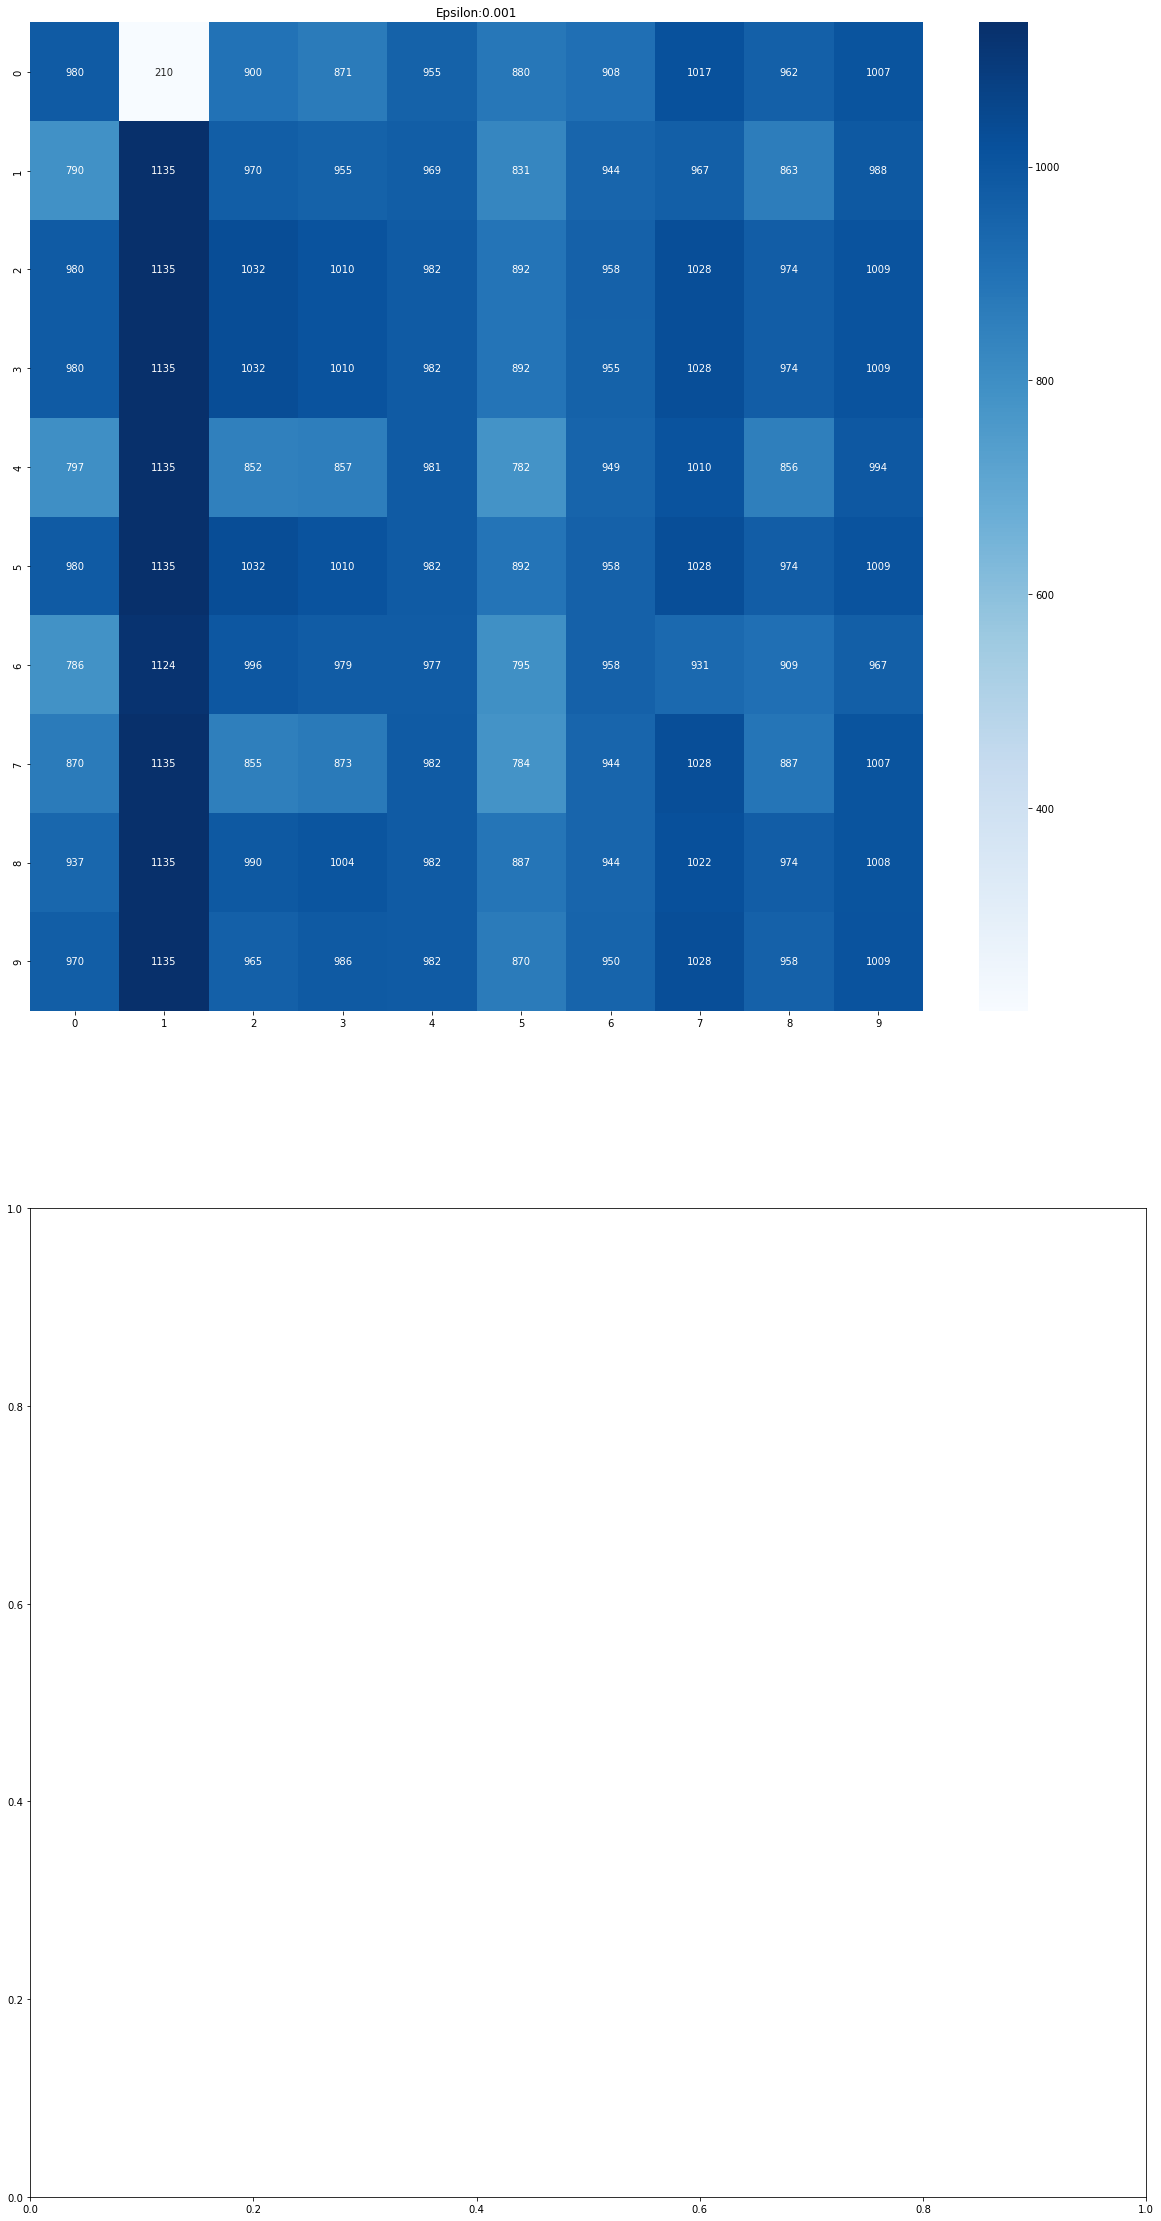

In [ ]:
"""
Test patterns
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)
"""
fig, axs = plt.subplots(nrows=2, figsize = (20, 40))
counter = 0
for epsilon in all_heatmaps:
    heatmap = all_heatmaps[epsilon]
    print(heatmap)
    df_cm = pd.DataFrame(heatmap, labels, labels)
    
    axs[counter].set_title("Epsilon:{}".format(epsilon))

    sn.heatmap( df_cm,ax = axs[counter], annot=True, cmap='Blues', fmt='g')
    counter+=1
fig.savefig('confusion_matrix{}.pdf'.format(datetime.now().strftime("%H-%M-%S")))
# print(intersection)

# RQ6:study the hot ReLU and the gradient
Do at least the following statistics on the activation patterns.
- What are the top k RELU with the highest gradient value (indicating that they are highly influential ReLU). If we only look at those ReLU, how many activation patterns do we have? This exp should be parametrized by k
- For activation patterns from images from the same label (e.g 7), what ReLU are stable, and what not? To check for stable, we set a threshold T%. If the value of the ith ReLU is the same for at least T% of the time, we say that ith ReLU is stable.
- Given that ith ReLU is stable for the label 7, is it also stable for a different label (e.g 9)? Note that for label 7, it may stable and always be 1, but for label 9, it may also be stable but with value 0.


#Checking ReLUs with highest gradient

